# 소스코드 주의 사항 

- 모델 개발과정과 사용방법을 담은 소스코드입니다. 
- 데이터셋은 포함하지 않아 코드 테스팅시 경로 재설정 및 수정이 필요합니다.
- 모델의 사용방법은 마지막에 표시하여 두었습니다. 
- 개발환경은 다음과 같습니다

[SoftWare]
JupyterNotebook ver6.4.8
Python3.9.1
CUDA 11.6

[HardWare]
인텔 코어 i9-12900H 14core
GeForce RTX3080Ti
DDR5 32GB



# 학습 데이터 

- ai hub의 차량 파손 데이터를 사용하였습니다.
    - jpg 형식의 이미지 데이터 63만장 
    - https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100
    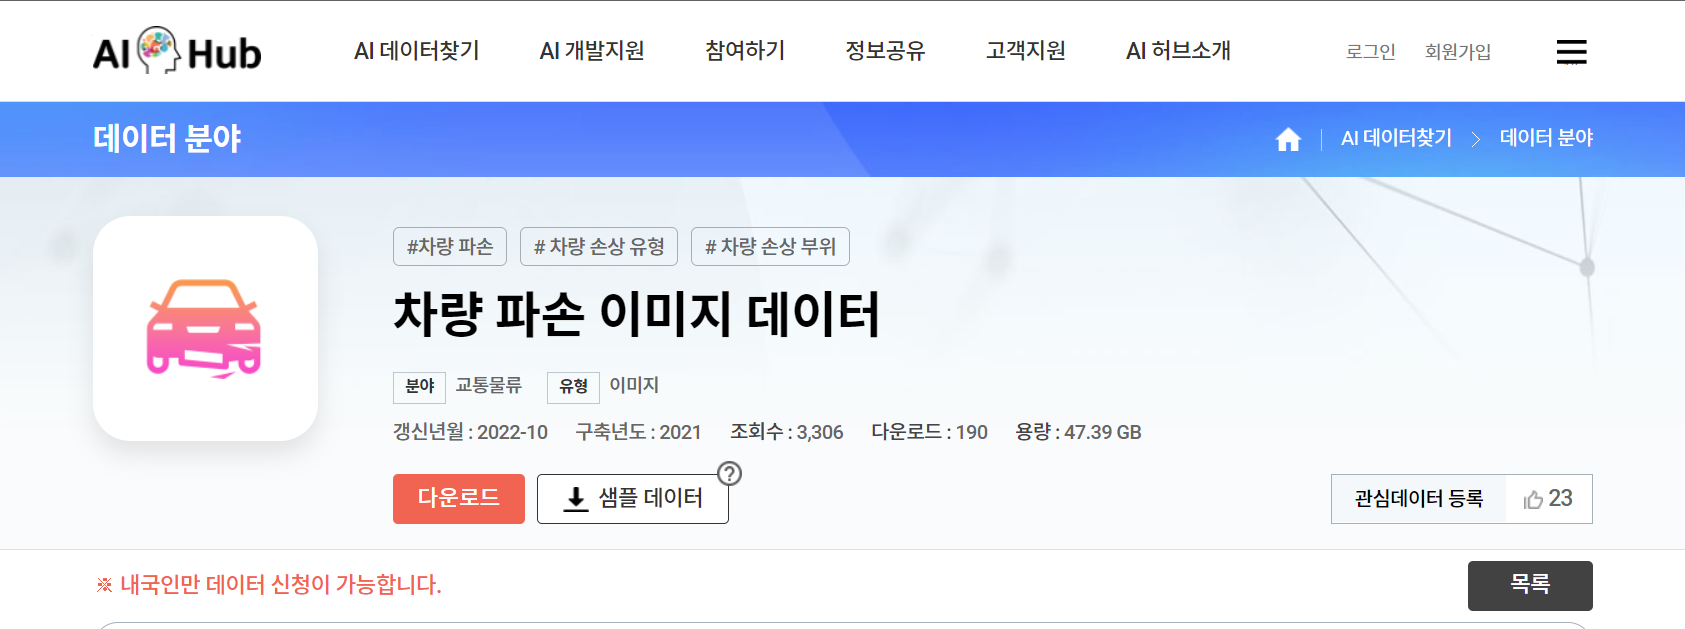
    

# 데이터 경로 설정과 전처리 과정

## 필요한 라이브러리 설치

In [1]:
!pip install tensorflow-gpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.10.0 which is incompatible.
tensorflow 2.9.1 requires tensorboard<2.10,>=2.9, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.9.1 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.10.0 which is incompatible.



  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12


In [ ]:
!pip install tensorflow

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [ ]:
pip install image

In [ ]:
# gpu 설정 
import tensorflow as tf
from tensorflow.python.client import device_lib

device_lib.list_local_devices()
tf.config.list_physical_devices('GPU')

# 인식한 GPU 개수 출력
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## dataset 폴더 생성 

- 이미지 데이터와 라벨링 데이터가 압축파일 형태여서 풀어야 한다. 

In [2]:
#경로 설정시 \를 제거하여 / 로 변경하는 코드 
r"C:\Users\AI\OneDrive\바탕 화면\공모전 잡파일\160. 차량파손 이미지 데이터\01.데이터\1.Training\1.원천데이터\damage".replace("\\","/")

'C:/Users/AI/OneDrive/바탕 화면/공모전 잡파일/160. 차량파손 이미지 데이터/01.데이터/1.Training/1.원천데이터/damage'

- 압축을 푼 파일을 저장하여 다른곳으로 저장한다. 
- 마찬가지로 라벨링 데이터도 같은 방식으로 사용한다.

In [ ]:

from zipfile import ZipFile as zf
import numpy as np
from PIL import Image
from io import BytesIO
import os

#zf(" 압축파일의 경로").extractall("압축을 풀 경로")

zf("/content/drive/MyDrive/Data/160. 차량파손 이미지 데이터/01.데이터/1.Training/1.원천데이터/TS_damage.zip").extractall("/content/damage_image")
zf("/content/drive/MyDrive/Data/160. 차량파손 이미지 데이터/01.데이터/1.Training/1.원천데이터/TS_damage_part.zip").extractall("/content/damage_part_image")
zf(("/content/drive/MyDrive/Data/160. 차량파손 이미지 데이터/01.데이터/2.Validation/1.원천데이터/VS_damage.zip").extractall("/content/val/damage_image")
zf("/content/drive/MyDrive/Data/160. 차량파손 이미지 데이터/01.데이터/2.Validation/1.원천데이터/VS_damage_part.zip").extractall("/content/val/damage_part_image")

In [ ]:
#현재 작업 공간 확인 
%pwd

In [ ]:
#디렉토리 변경
%cd 

In [ ]:
#dataset 디렉토리 만들기 
%mkdir dataset

- 사용한 dataset 폴더의 디렉토리 구조는 다음과 같습니다 

- dataset 
    - train 
        - images, labels
    - val
        - images, labels

# label 데이터를 가져와서 정리

In [ ]:
import os
from glob import glob

# damage_labeling
label_list_json_dir1="/content/label/damage_image/damage/"
label_list_json_file1=os.listdir(label_list_json_dir)

In [ ]:
# 라벨데이터 개수 확인 
len(label_list_json_file1)

- 라벨링된 데이터의 클래스 값은 aihub의 첨부된 데이터 설명서를 참조하였습니다. 
    - 다만 값을 확인하기 위해 코드로 json 파일을 열어 클래스를 확인해 보았습니다. 
    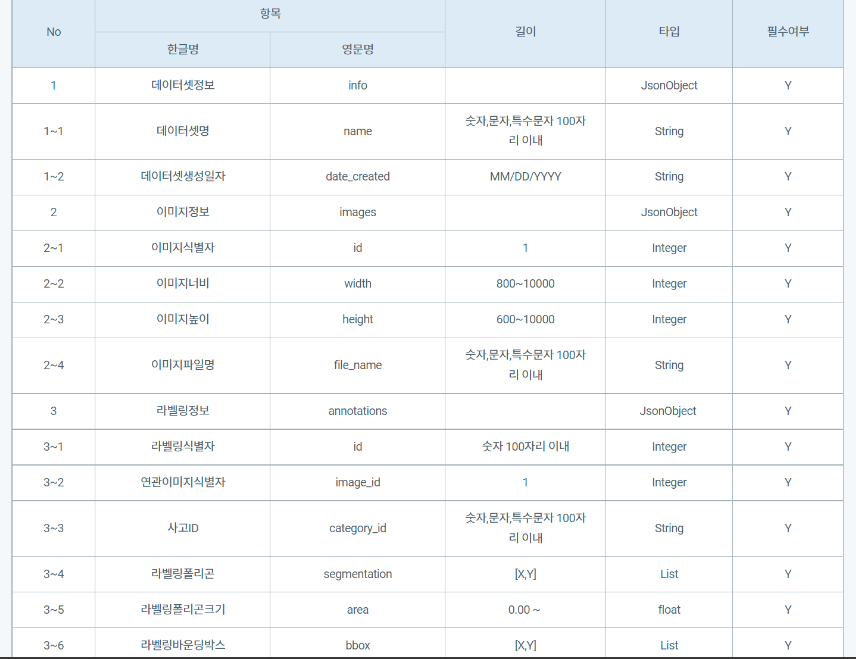
    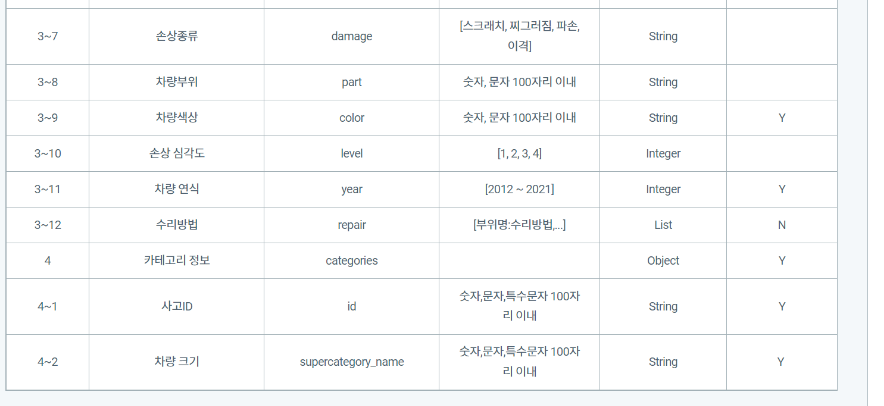

- json의 키 값 정리 
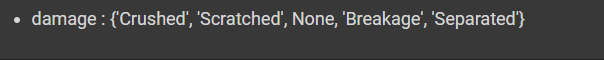

## json 파일을 가져와서 bbox 좌표 변환 및 txt 파일로 변환 

- yolo 모델의 경우 bbox의 좌표는 (x,y,w,h)
    - 여기서 x,y는 박스의 중심값

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt

lctn_list = []
# damage = [None, 'Crushed', 'Scratched', 'Breakage', 'Separated']

for file in label_list_json_file1:
    with open(label_list_json_dir1 +"/"+file) as f :
        json_data = json.load(f)
        
        f_name2 = json_data["images"]["file_name"][:-4]
        width = json_data["images"]["width"]  # 이미지 너비
        height = json_data["images"]["height"]  # 이미지 높이
        
        with open(f"/content/label/damage_image/{f_name2}.txt", 'w') as f1 :
            for d in json_data['annotations']:
                x1, y1, x2, y2 = d["bbox"]  # bbox의 왼쪽 상단(x1, y1), 오른쪽하단(x2, y2 좌표)
                x, y = (x1 + (x1 + x2)) / 2 / width,(y1 + (y1-y2)) / 2 / height  # YOLO 모델에 넣을 이미지에 대한 bbox 중앙점의 상대적 좌표(x, y) 
                w, h = x2 / width, y2 / height  # YOLO 모델에 넣을 bbox의 이미지에 대한 상대적 너비, 높이

                if d["damage"] == None:
                    num = 0
                elif d["damage"] == 'Crushed':
                    num = 1
                elif d["damage"] == 'Scratched':
                    num = 2
                elif d["damage"] == 'Breakage':
                    num = 3
                elif d["damage"] == 'Separated':
                    num = 4 

                bbox = ' '.join(map(str, [num, x, y, w, h]))

                if d["damage"] == None :
                    f1.write(f'0 {bbox}\n')  # txt파일에 클래스 인덱스 0 bbox값(x y w h) 쓰기                            

                # damage가 null이 아니면,
                else :
                    f1.write(f'{bbox}\n') # txt파일에 클래스 인덱스와 bbox값(x y w h) 쓰기  

### txt 데이터를 dataset에 이동시키기 


In [ ]:
import shutil

label_list1=glob("/content/label/damage_image/*.txt")

for i in label_list1:
    shutil.move(i, "/content/dataset/train/labels")

## dataset 확인

- 이미지 데이터
- 라벨링 데이터
- 훈련, val 확인 

In [ ]:
dataset1=glob("/content/dataset/train/images/*.jpg")

len(dataset1)

## data.yaml 파일 만들기

In [ ]:
data={}# 빈 딕트 

data["train"]="/content/dataset/train/images"
data["val"]="/content/dataset/val/images"

data['nc']= 5
data['names']=['None',
'Crushed',
'Scratched',
'Breakage',
'Separated']

In [ ]:
import  yaml

with open('/content/dataset/data.yaml','w') as f:
    yaml.dump(data,f)

# yolo v7 모델에 학습시키기

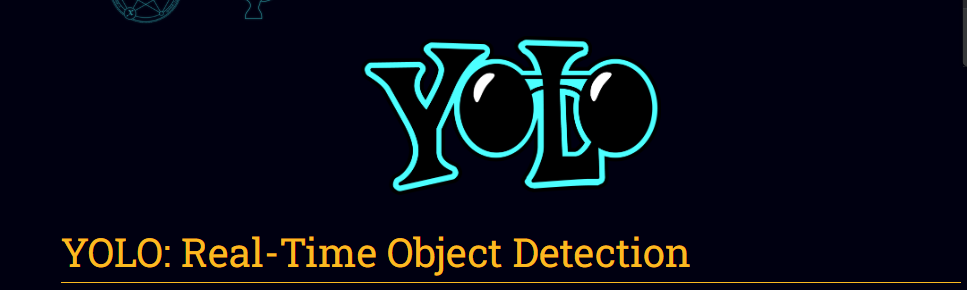

- 이미지 기반 객체 탐지에 사용되는 모델 


In [ ]:
#yolo v7 가져오기 
!git clone https://github.com/WongKinYiu/yolov7.git

In [ ]:
# 학습 모듈 실행

#경고 무시
#import warnings
#warnings.filterwarnings("ignore")
# 사용할 파이썬 파일
python_t = 'train.py'
# 사용할 데이터를 적어둔 yaml file
data = '/content/dataset/data.yaml'
# 사용할 모델 구조 (x>l>n>m>s)
cfg = '/content/yolov7/cfg/training/yolov7.yaml'

# 사용할 가중치
weights = './yolov7.pt'
# 학습 결과를 저장할 폴더 이름
name = '/content/yolov7/car_destroy/yolov7_val.'

!python {python_t} --batch 16 --epochs 20 --data {data} --cfg {cfg} --weights {weights} --name {name}

# 모델 사용 및 평가 

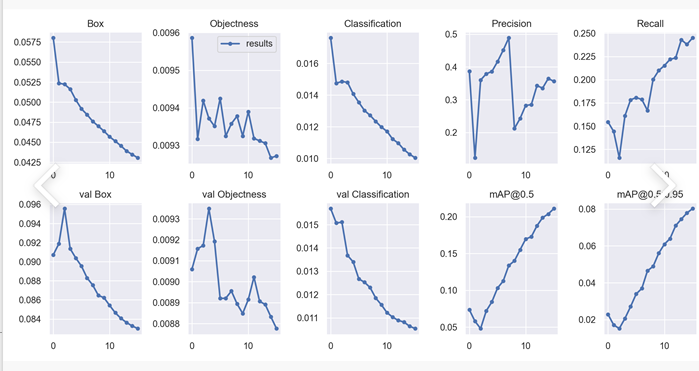
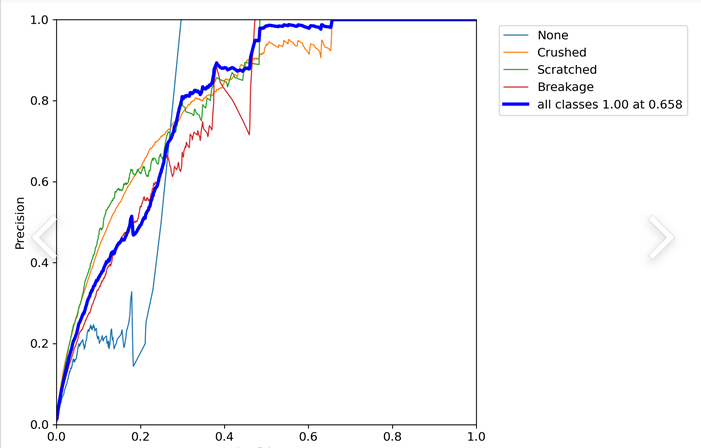

## 학습된 모델 사용하기 

- car_detection: 학습완료된 모델의 가중치 경로: "yolov7/car_detection/best.pt"
- test_img: 객체 인식에 사용될 이미지

In [ ]:
rs = !python detect.py --weights "{car_detection}" --img 416 --conf 0.06 --source "{test_img}"
rs